In [1]:
import numpy as np
import torch
import torch.nn as nn
import gc
import matplotlib.pyplot as plt
from itertools import product
from models import  ResNet, ResidualBlock
from utils.visualization import visualize, plot_tsne_2d, plot_tsne_3d
from utils.data_loader import data_loader, full_data_loader
from utils.utils import encoding, svc_classification
from torchvision.models import resnet34
import seaborn as sns
import csv

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
trained_model_path = "./trained_models/ResNet-final.pth"

# task 1
dataset_colorectal_cancer_path = "./datasets/Colorectal Cancer"
label_tags_colorectal = ["MUS", "NORM", "STR"]

# task 2
dataset_prostate_path = "./datasets/Prostate Cancer"
label_tags_prostate=["gland", "nongland", "tumor"]


dataset_animal_path = "./datasets/Animal Faces"
label_tags_animals = ["cat", "dog", "wild"]

torch.zeros(1).cuda()

SEED = 42
TEST_SIZE = 0.3
VALIDATION_SIZE = 0.1

# Flags
OPTIMIZE_HYPERPARAMETERS = False
LOAD_TRAINED_MODEL = True
TRAIN_MODEL = False

cuda


## Load the data into DataLoader
In this step, data is reshaped and normalized
- Normalization helps eliminate the effects of lighting (brightness, contrast, etc.) and other factors that may affect the image, leading to better training performance.


In [2]:
training_loader, test_loader, test_loader = data_loader(data_path=dataset_colorectal_cancer_path, batch_size=64, test_size=0.3)

## Finding best hyperparameter 
The following code is used to find the best hyperparameters for the model by performing a grid search with various combinations of batch size and learning rate.

In [3]:
# Grid search parameters
batch_sizes = [16, 32, 64, 128]
learning_rates = [0.001, 0.01, 0.05, 0.1]

learning_rate = 0.01
momentum = 0.9
weight_decay = 0.001
num_epochs = 30

if OPTIMIZE_HYPERPARAMETERS:
    grid_search_results = {}

    criterion = nn.CrossEntropyLoss()

    # Perform grid search
    for bs, lr in product(batch_sizes, learning_rates):
        print(f"\nTraining with batch_size={bs}, learning_rate={lr}")

        # Update parameters
        batch_size = bs
        learning_rate = lr

        # Reinitialize model and optimizer
        model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)
        optimizer = torch.optim.SGD(model.parameters(),
                                    lr=learning_rate,
                                    momentum=momentum,
                                    weight_decay=weight_decay)

        # Training loop
        train_losses = []
        validation_losses = []
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for i, (images, labels) in enumerate(training_loader):
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                del images, labels, outputs

            # Calculate average training loss for epoch
            train_epoch_loss = running_loss / len(training_loader)
            train_losses.append(train_epoch_loss)

            # Calculate validation loss
            model.eval()
            val_running_loss = 0.0
            with torch.no_grad():
                for images, labels in test_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_running_loss += loss.item()

            val_epoch_loss = val_running_loss / len(test_loader)
            validation_losses.append(val_epoch_loss)

            if (epoch + 1) % 5 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}')

        # Plot training vs validation loss
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
        plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Training vs Validation Loss (batch_size={bs}, learning_rate={lr})')
        plt.legend()
        plt.show()

        # Store results
        grid_search_results[(bs, lr)] = min(validation_losses)




In [4]:
if OPTIMIZE_HYPERPARAMETERS:
    with open("hyperparameter-search-results.csv", mode="w", newline="") as file:
        writer = csv.writer(file)

        writer.writerow(["batch_size", "learning_rate", "validation_loss"])

        for (bs,lr), loss in grid_search_results.items(): 
            writer.writerow([bs,lr,loss])

    # Create a matrix to hold the validation losses
    loss_matrix = np.zeros((len(batch_sizes), len(learning_rates)))

    for i, bs in enumerate(batch_sizes):
        for j, lr in enumerate(learning_rates):
            loss_matrix[i, j] = grid_search_results[(bs, lr)]

    plt.figure(figsize=(10, 8))
    sns.heatmap(loss_matrix, annot=True, fmt=".4f", cmap='coolwarm',
                xticklabels=learning_rates, yticklabels=batch_sizes)
    plt.xlabel('Learning Rate')
    plt.ylabel('Batch Size')
    plt.title('Grid Search Results: Validation Loss for Batch Size and Learning Rate Combinations')
    plt.show()

    best_params = min(grid_search_results.items(), key=lambda x: x[1])
    print(f"\nBest parameters: batch_size={best_params[0][0]}, learning_rate={best_params[0][1]}")
    print(f"Best validation loss: {best_params[1]:.4f}")

## Training the Model

In [5]:
## Training the Model
batch_size = 32
num_epochs = 30
learning_rate = 0.001

model = ResNet(ResidualBlock, [2, 4, 6, 3]).to(device)

if LOAD_TRAINED_MODEL:
    model.load_state_dict(torch.load(trained_model_path,map_location=torch.device(device)))

#Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = weight_decay, momentum = momentum)

#Train the model
total_step = len(training_loader)

train_validation_loss = []

if not LOAD_TRAINED_MODEL:
  for epoch in range(num_epochs):
      for i, (images, labels) in enumerate(training_loader):
        # move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backpropagate and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # free up memory that is no longer in use
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

      print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

      # Validation
      with torch.no_grad():
          correct = 0
          total = 0
          for images, labels in test_loader:
              # move tensors to device
              images = images.to(device)
              labels = labels.to(device)

              # get predictions
              outputs = model(images)
              _, predicted = torch.max(outputs.data, 1)

              # update total and correct
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

              # free up memory
              del images, labels, outputs

          print('Accuracy of the network on the {} test images: {} %'.format(len(test_loader.dataset), 100 * correct / total))

      # Calculate and store training loss
      train_loss = 0.0
      with torch.no_grad():
          for images, labels in training_loader:
              images = images.to(device)
              labels = labels.to(device)
              outputs = model(images)
              train_loss += criterion(outputs, labels).item()
              del images, labels, outputs
          train_loss /= len(training_loader)

      # Calculate and store validation loss
      test_loss = 0.0
      with torch.no_grad():
          for images, labels in test_loader:
              images = images.to(device)
              labels = labels.to(device)
              outputs = model(images)
              test_loss += criterion(outputs, labels).item()
              del images, labels, outputs
          test_loss /= len(test_loader)

      train_validation_loss.append({"train": train_loss, "test": test_loss})

  # Plot training and validation loss
  plt.figure(figsize=(10, 6))
  epochs = range(1, len(train_validation_loss) + 1)
  train_losses = [x["train"] for x in train_validation_loss]
  val_losses = [x["test"] for x in train_validation_loss]

  # Calculate mean and std for both losses
  train_mean, train_std = np.mean(train_losses), np.std(train_losses)
  val_mean, val_std = np.mean(val_losses), np.std(val_losses)

  # Filter data within 2 standard deviations
  train_mask = np.abs(train_losses - train_mean) <= 2 * train_std
  val_mask = np.abs(val_losses - val_mean) <= 2 * val_std

  # Plot filtered data
  plt.plot(np.array(epochs)[train_mask], np.array(train_losses)[train_mask],
           color="blue", label='Training Loss')
  plt.plot(np.array(epochs)[val_mask], np.array(val_losses)[val_mask],
           color="orange", label='Test Loss')
  plt.title('Training and Test Loss over Epochs (Within 2σ)')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  torch.save(model.state_dict(), trained_model_path)

## Test the model

In [6]:
if TRAIN_MODEL:
    with torch.no_grad():
        correct = 0
        total = 0

        for images, labels in test_loader:
            # move tensors to device
            images = images.to(device)
            labels = labels.to(device)

            # get predictions
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            # update total and correct
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # free up memory
            del images, labels, outputs

        print('Accuracy of the network on the {} test images: {} %'.format(len(test_loader.dataset), 100 * correct / total))

## Visualizing TSNE Feature extractions from dataset 1 with custom ResNet-34

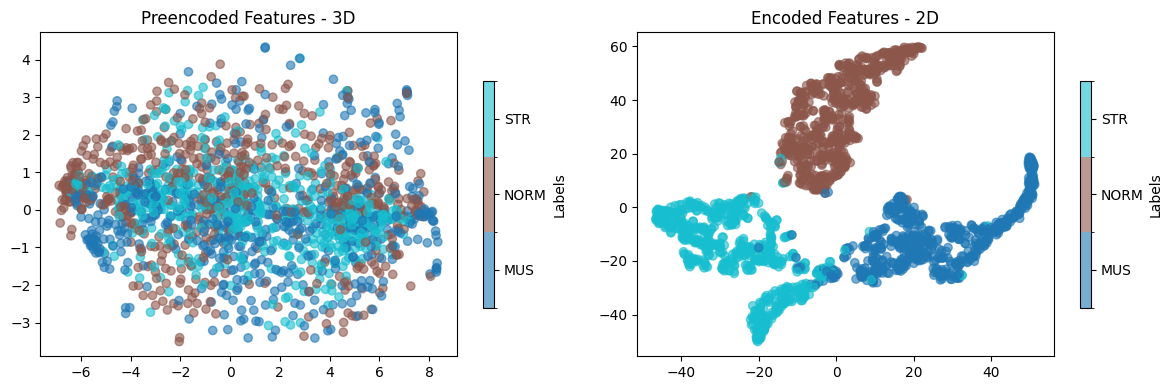

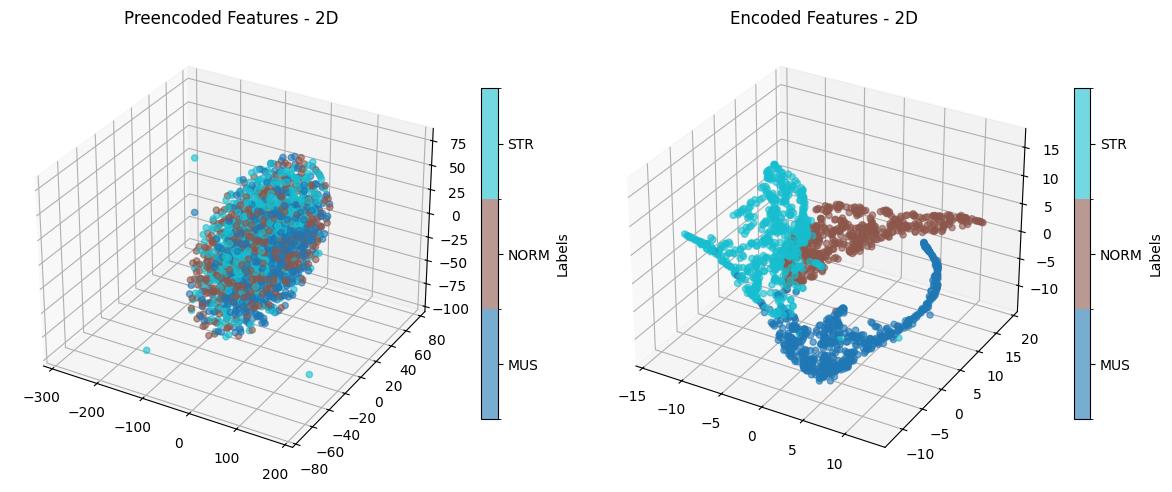

In [7]:
encoded_tsne_2d,encoded_tsne_3d,preencoded_tsne_2d,preencoded_tsne_3d,preencoded_features,encoded_features,labels_list = encoding(model,test_loader, device)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plot_tsne_2d(preencoded_tsne_2d, encoded_tsne_2d, labels_list, axs, label_tags_colorectal, fig)

plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(12, 10))
plot_tsne_3d(preencoded_tsne_3d, encoded_tsne_3d,labels_list,label_tags_colorectal, fig)

plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.tight_layout()
plt.show()

## TASK 2

---

- Visualize feature extraction for Dataset 2 and 3.  
    1. Using our trained ResNet-34 on Dataset 1
    2. Using pre-trained ResNet-34 on IMAGENET

- Train on classical ML model


### Defining Pre-trained ImageNet Model

In [8]:
# Initializing ResNet-34 pre-trained on IMAGENET
model_on_imageNet = resnet34(weights='IMAGENET1K_V1')

### Dataset 2
- loading data
- visualize extracted features from prerained model

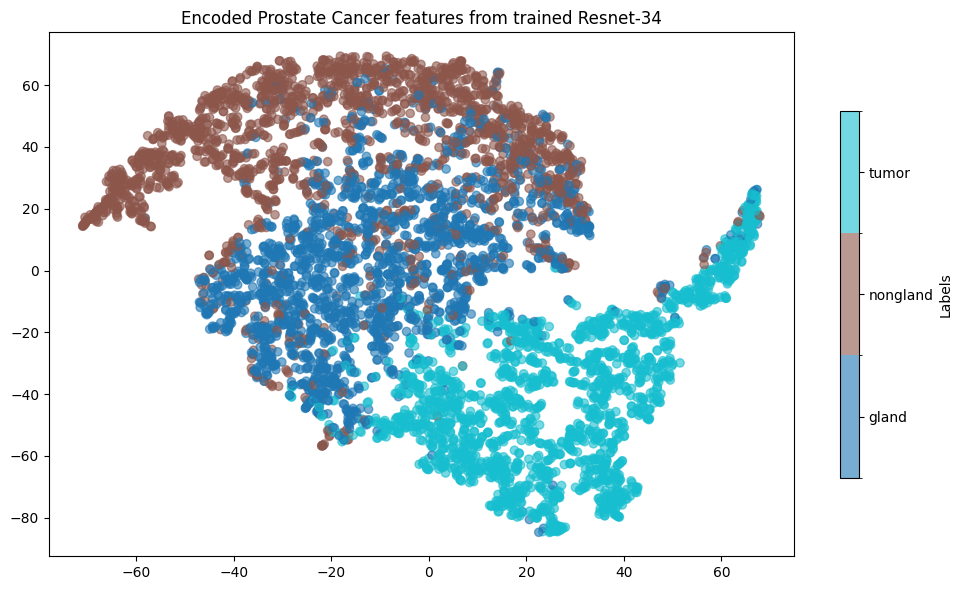

In [9]:
# load data
prostate_full_loader = full_data_loader(dataset_prostate_path, batch_size=64)

# visualize extracted features from prerained Restnet-34 model
prostate_trained_resnet_features = visualize(model,prostate_full_loader,label_tags_prostate,'Encoded Prostate Cancer features from trained Resnet-34', device)


### Pre-Trained ImageNet model

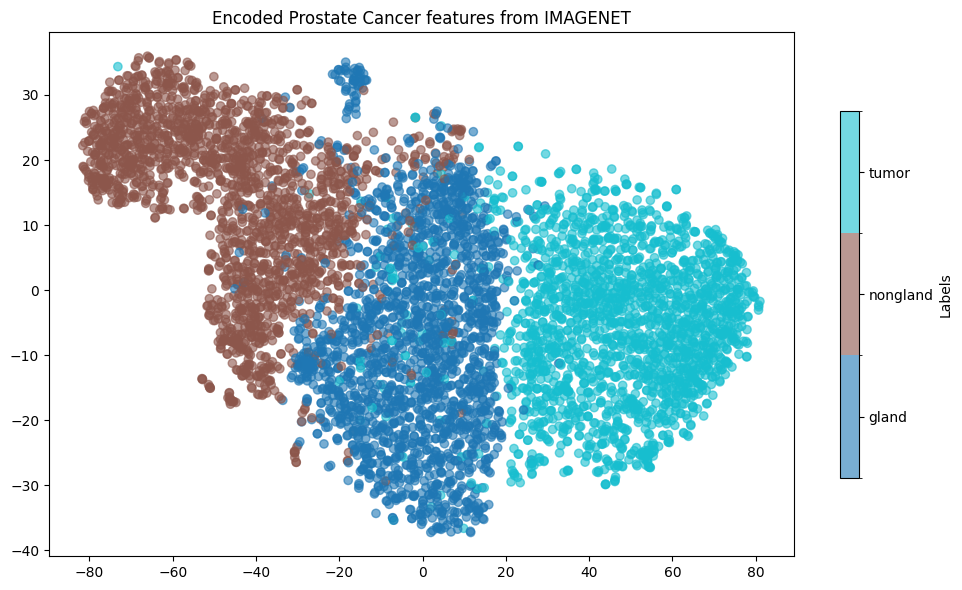

In [10]:
prostate_imagenet_fe = visualize(model_on_imageNet,prostate_full_loader,label_tags_prostate,'Encoded Prostate Cancer features from IMAGENET', device)

## Dataset 3

In [11]:
animal_full_loader = full_data_loader(dataset_animal_path, batch_size=64)

### Trained Restnet-34 model

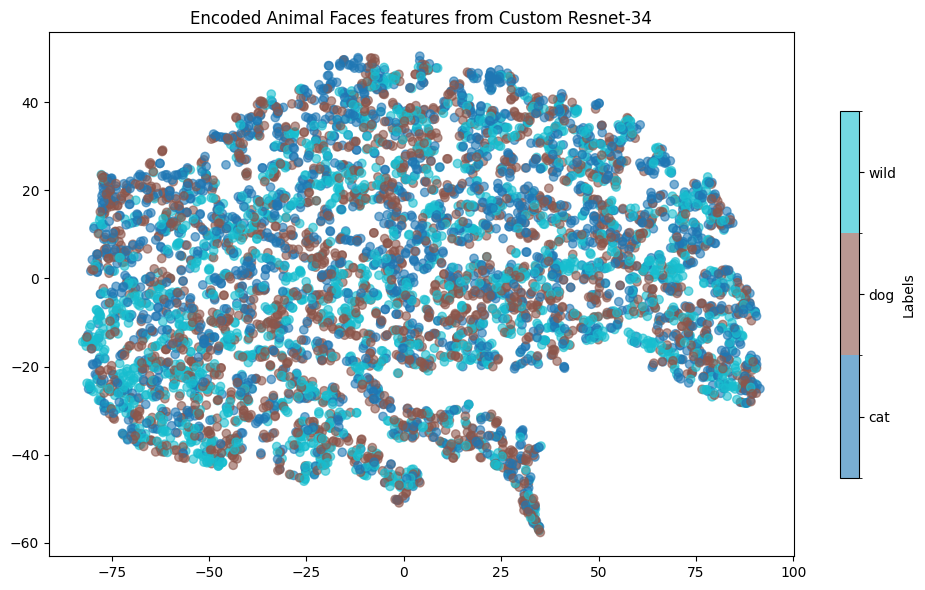

In [12]:
animal_custom_model_fe = visualize(model, animal_full_loader, label_tags_animals, 'Encoded Animal Faces features from Custom Resnet-34', device)

### Pre-Trained ImageNet model

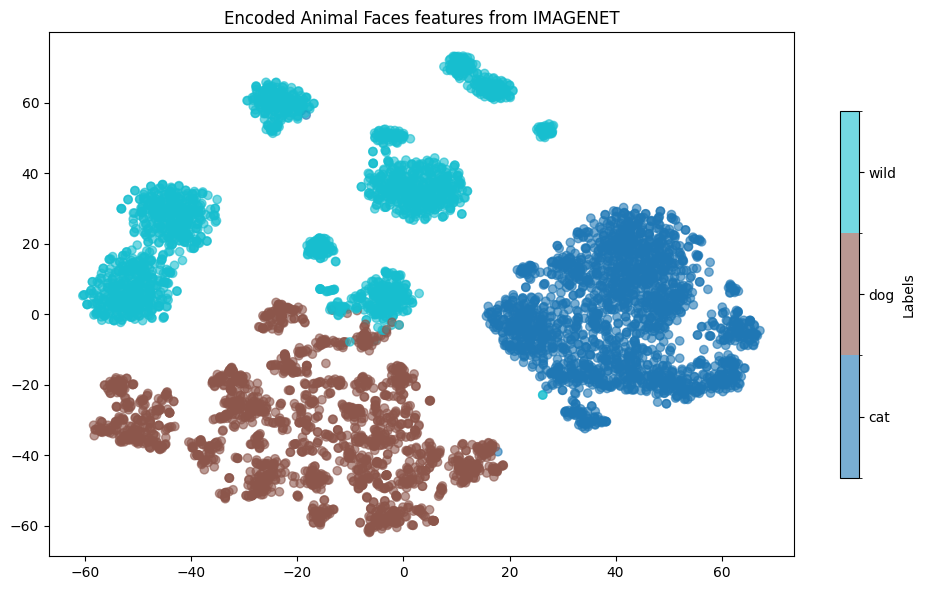

In [13]:
animal_imagenet_fe = visualize(model_on_imageNet,animal_full_loader,label_tags_animals,'Encoded Animal Faces features from IMAGENET', device)

## Classification

### Classification using SVC on Dataset 2

#### IMAGENET Features

Accuracy - Prostate Cancer (IMAGENET): 93.17%
              precision    recall  f1-score   support

       gland       0.88      0.92      0.90       606
    nongland       0.93      0.92      0.93       590
       tumor       0.98      0.95      0.97       604

    accuracy                           0.93      1800
   macro avg       0.93      0.93      0.93      1800
weighted avg       0.93      0.93      0.93      1800



ValueError: 'c' argument has 1800 elements, which is inconsistent with 'x' and 'y' with size 4200.

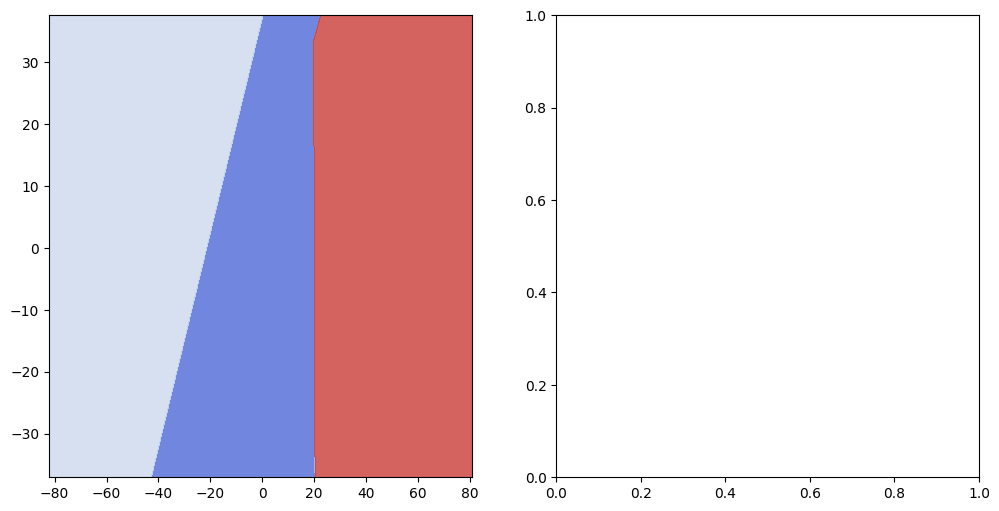

In [14]:
svc_classification(
    dataset=prostate_full_loader,
    feature_extractor=prostate_imagenet_fe,
    class_labels=label_tags_prostate,
    model_label="IMAGENET",
    dataset_label="Prostate Cancer",
    test_size=TEST_SIZE,
    seed=SEED,
    device=device
)

#### Trained Model

ValueError: 'c' argument has 1800 elements, which is inconsistent with 'x' and 'y' with size 4200.

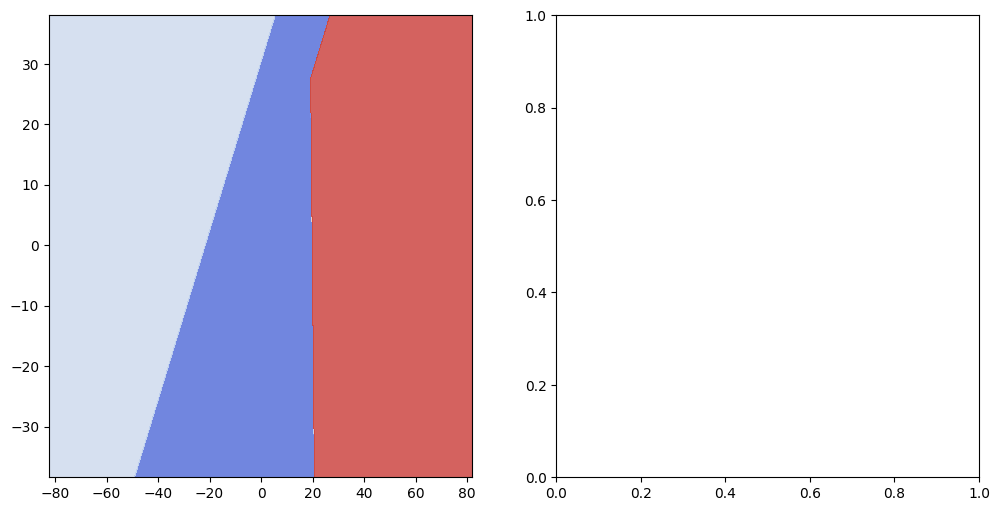

In [17]:
svc_classification(
    dataset=prostate_full_loader,
    feature_extractor=prostate_imagenet_fe,
    class_labels=label_tags_prostate,
    model_label="Trained Resnet-34",
    dataset_label="Prostate Cancer",
    test_size=TEST_SIZE,
    seed=SEED,
    device=device
)

### Classification using SVM for dataset 3

#### IMAGENET

In [ ]:
svc_classification(
    dataset=animal_full_loader,
    feature_extractor=animal_imagenet_fe,
    class_labels=label_tags_animals,
    model_label="IMAGENET",
    dataset_label="Prostate Cancer",
    test_size=TEST_SIZE,
    seed=SEED,
    device=device
)


#### Trained Model

In [ ]:
svc_classification(
    dataset=animal_full_loader,
    feature_extractor=animal_custom_model_fe,
    class_labels=label_tags_animals,
    model_label="Trained Resnet-34",
    dataset_label="Animal Faces",
    test_size=TEST_SIZE,
    seed=SEED,
    device=device
)